# Decision Tree
A decision tree is a supervised, nonparametric machine learning algorithm used for both classification and regression tasks. A decision tree recursively partitions the feature space into disjoint subsets, where any given datapoint can be placed into one of these subsets based on the values of its features. The response value/label of the given datapoint can be infered by the subset that it falls into.

Decision trees can be conceptualized as binary trees in the graph theory sense: Internal nodes represent data features, branches represent decisions or rules for how to traverse down the tree, and leaf nodes represent the predicted value/label. If we want to make a prediction on some testing input, we start at the root node and find the value of the data feature associated with the root node. We then traverse the branch associated with the feature's value to reach a new internal node. We repeat this process for the new internal node until we have traversed down the tree to a leaf node. The leaf node gives us our predicted response value/label.

{PICTURE}


## Classification
We will implement a decision tree classifier from scratch. Our implementation draws heavily inspiration from [Joachim Valente](https://towardsdatascience.com/decision-tree-from-scratch-in-python-46e99dfea775) because Dr. Davila's INDE 577 lecture repository uses a packaged decision tree classifier.

We will demonstrate a decision tree classifier for the same problem as we did for the K-nearest neighbors demonstration in `KNearestNeighbors.ipynb`. We want to use our decision tree to decide if a given LEGO set is of the Duplo, Bionicle, or Education theme. Our two data features are the weight of the LEGO sets and the number of pieces of the LEGO sets.

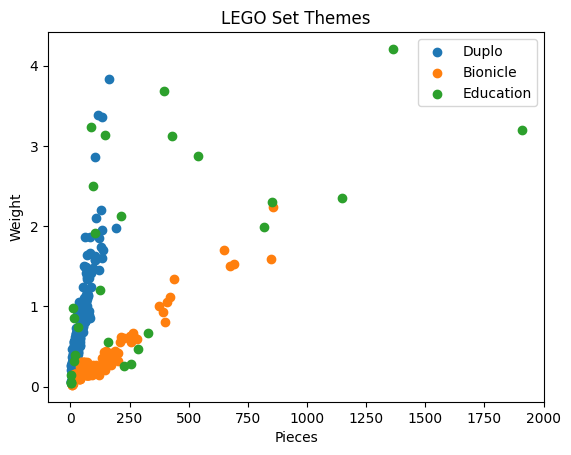

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Read in dataset and keep relevant columns/rows
df = pd.read_csv('data/Brickset-Most-Owned-Query-33-02042023.csv', index_col="Number")
df = df.filter(["Theme", "Pieces", "Weight", "RRP (USD)"])
df.columns = ["Theme", "Pieces", "Weight", "RRP"]
df = df[(df["Theme"] == "Duplo")
        | (df["Theme"] == "Bionicle")
        | (df["Theme"] == "Education")]
df = df.dropna()

# Write inicators
df["Indicator"] = np.where(df["Theme"] == "Duplo", 0,
                  np.where(df["Theme"] == "Bionicle", 1,
                  np.where(df["Theme"] == "Education", 2, -1)))

# Plot datapoints
themes = ["Duplo", "Bionicle", "Education"]
for theme in themes:
    bool_inds = df["Theme"] == theme
    plt.scatter(df["Pieces"][bool_inds], df["Weight"][bool_inds], label=theme)
plt.legend()
plt.title("LEGO Set Themes")
plt.xlabel("Pieces")
plt.ylabel("Weight")
plt.show()

# Train/test split of data
X_train, X_test, y_train, y_test = train_test_split(df[["Pieces", "Weight"]].to_numpy(),
                                                    df["Indicator"].to_numpy(), 
                                                    test_size=0.3, 
                                                    random_state=0)

### Gini impurity
Decision trees are trained based on the principle of maximizing the "purity"/minimizing the "entropy" of information. In other words, the decision tree would like to partition the feature space such that the training data are as homogeneous as possible within each subset.

One way to measure the purity of data is with the Gini impurity metric. Suppose $C$ is the set of possible categorical data labels; in our case, $C = \{\text{Duplo, Bionicle, Education}\} = \{0, 1, 2\}$. Suppose our data sample has $n$ datapoints, and suppose $n_c$ is the number of the data points inside category $c \in C$. The Gini impurity metric is defined as:

$\begin{align*}
    G = 1 - \sum\limits_{c \in C} \big{(} \frac{n_c}{n} \big{)} ^2
\end{align*}$

The goal of the decision tree is to partition the feature space to minimize the Gini impurity within each subset.

In [2]:
def gini_impurity(labels):
    '''
    Computes the Gini impurity of input dataset
    INPUT
        labels; (n, )-shape numpy array, where element i is the count of datapoints with label i in the dataset
    RETURN
        Gini impurity
    '''
    labels_fraction = labels[labels > 0] / np.sum(labels)
    return 1 - np.sum(np.square(labels_fraction))

### Entropy
Entropy is one alternative to the Gini impurity metric. We would like to minimize entropy within each subset of the decision tree's partition.

$\begin{align*}
    E = - \sum\limits_{c \in C} \frac{n_c}{n} \log \big{(} \frac{n_c}{n} \big{)}
\end{align*}$


In [3]:
def entropy(labels):
    '''
    Computes the entropy of input dataset
    INPUT
        labels; (n, )-shape numpy array, where element i is the count of datapoints with label i in the dataset
    RETURN
        Entropy
    '''
    labels_fraction = labels[labels > 0] / np.sum(labels)
    return - np.sum(np.multiply(labels_fraction, np.log(labels_fraction)))

### Splitting the feature space
To train the decision tree classifier, we need to decide the branching rule at each node. Suppose for some node, the applicable datapoints are $i \in \{1, ..., n\}$ with input features $x^i \in \mathbb{R}^m$ and response labels $y^i \in C$. We can use the following procedure to decide the how to split the feature space to minimize some impurity metric $f$ in each of the two subsets. If none of the possible splits improve the impurity of the node, then no split is necessary.

1. $bestImpurity \gets f(\{y_1, ..., y_n\}$
2. $j^* \gets \text{NONE}, i^* \gets \text{NONE}$
3. Foreach $j \in \{1, ..., m\}$ and Foreach $i \in \{1, ..., n-1\}$:
  1. $leftImpurity \gets f(\{y_1, ... , y_i\})$
  2. $rightImpurity \gets f(\{y_{i+1}, ..., y_n\}$
  3. $avgImpurity \gets \frac{i}{n} leftImpurity + \frac{n-i}{n} rightImpurity$
  4. If $avgImpurity < bestImpurity$, then $bestImpurity \gets avgImpurity, j^* \gets j, i^* \gets i$
4. If $j^*, i^* \neq \text{NONE}$, then split feature space by $\{i \in [n] | x^i_{j^*} \leq x^{i^*}_{j^*}\}, \{i \in [n] | x^i_{j^*} > x^{i^*}_{j^*}\}$

We implement this feature-space split procedure in a `Node` class, which represents a node within the decision tree.

In [4]:
class Node:
    '''
    This Node object represents one of the nodes of the decision tree classifier.
    '''
    
    depth = 0               # The depth of this node within the decision tree
    predicted_label = None  # The label predicted by this node. If this is a leaf node, any inputs that land on this node will be predicted to have this label.
    split_feature = None    # The index of the feature to branch across
    split_threshold = None  # The threshold of the branch
    left_child = None       # The node at the left branch, if this node is not a leaf node
    right_child = None      # The node at the right branch, if this node is not a leaf node
    
    def __init__(self, depth=0):
        '''
        Initializes this node
        INPUT
            depth; the depth of this node within the decision tree
        '''
        self.depth = depth
    
    def make_branch(self, x_feature, y_label, max_depth, impurity_metric=gini_impurity):
        '''
        Makes a branch from this node if the node's depth is not already at max_depth.
        Iterates through every possible feature to branch off of and every threshold within those features.
        Records the feature/threshold that minimizes impurity.
        Then, makes the branch and creates two child Node objects. Calls make_branch on these children. Recursively constructs decision tree this way.
        INPUT
            x_feature; (n, m)-shape numpy array representing the training input data
            y_label; (n, )-shape numpy array representing the training data labels, where the labels are integers 0, 1, 2, ...
            max_depth; positive integer representing the maximum depth of the decision tree
            impurity_metric; a function that computes an impurity score
                                INPUT: a (n, )-shape numpy array, where element i is the count of datapoints with label i in the dataset
                                RETURNS: the impurity score of the input
        '''
        
        # Set this node's predicted label as the most common label among y_label
        self.predicted_label = np.bincount(y_label).argmax()
        
        # If we have reached the tree's max depth, then this node is a leaf node and does not branch
        if self.depth == max_depth:
            self.split_feature = None
            self.split_threshold = None
            return
        
        # Get the shape of the input
        (n_data, n_features) = x_feature.shape
        
        # If there are fewer than two training datapoints, then there is no way to split the data. Then, this node is a leaf node and does not branch.
        if n_data < 2:
            self.split_feature = None
            self.split_threshold = None
            return
                
        # Create a vector representing the data labels. The ith entry represents the number of instances of label i within y_label.
        node_labels = np.zeros((np.max(y_label) + 1, ))
        for lab in y_label:
            node_labels[lab] += 1

        # These variables record the branching feature and threshold that yields the lowest impurity
        # best_impurity initializes to the initial impurity of all the input data. If no branching feature/threshold has lower impurity than the entire dataset, then no branching is necessary, and we have a leaf node. 
        best_impurity = impurity_metric(y_label) 
        best_feature = None
        best_threshold = None
        
        # Iterate through each feature
        for feature in range(n_features):
            
            # Sort the input data values and data labels by the feature value, in ascending order
            thresholds, labels = zip(*sorted(zip(x_feature[:, feature], y_label)))
            
            # These vectors represent the data labels within the data in the left and right sides of the split, respectively.
            # The ith entry represents the number of instances of label i within y_label.
            left_labels = np.zeros(node_labels.shape)
            right_labels = node_labels.copy()
            
            # Iterate through each threshold/datapoint feature value
            for ind in range(n_data - 1):
                
                # If this datapoint's feature value is the same as the next datapoint's feature value, we don't need to evaluate this datapoint
                # because we would split at this datapoint if and only if we also split at the next datapoint.
                if thresholds[ind] == thresholds[ind + 1]:
                    continue
                
                # Record this datapoint's label.
                # Record that if this threshold is selected to branch,
                # then this datapoint would belong to the left branch instead of the right branch.
                this_label = labels[ind]
                left_labels[this_label] += 1
                right_labels[this_label] -= 1
                
                # Compute impurity of this branch
                left_impurity = impurity_metric(left_labels)
                right_impurity = impurity_metric(right_labels)
                avg_impurity = (ind * left_impurity + (n_data - ind) * right_impurity) / n_data
                
                # Record if this branch yields the lowest impurity
                if avg_impurity < best_impurity:
                    best_impurity = avg_impurity
                    best_feature = feature
                    best_threshold = (thresholds[ind] + thresholds[ind + 1]) / 2
        
        # Store the best branch in the object properties
        self.split_feature = best_feature
        self.split_threshold = best_threshold      
        
        # If a branch was found/this is not a leaf node, then create child Nodes at the ends of the branch.
        # Call make_branch on both children Nodes to recursively build decision tree
        if (best_feature is not None) and (best_threshold is not None):
            self.left_child = Node(depth=self.depth + 1)
            inds = x_feature[:, best_feature] <= best_threshold
            self.left_child.make_branch(x_feature[inds, :], y_label[inds], max_depth, impurity_metric)

            self.right_child = Node(depth=self.depth + 1)
            inds = x_feature[:, best_feature] > best_threshold
            self.right_child.make_branch(x_feature[inds, :], y_label[inds], max_depth, impurity_metric)
            
    def is_leaf_node(self):
        '''
        RETURNS if this Node is a leaf node
        '''
        return (self.split_feature is None)

### Constructing the decision tree
We now know how to split each node into its branches. How do we the entire tree? We can create a `Node` as the root node and branch the node using `make_branch`. Then, we can create two children nodes using this branch. We continue branching in this way until a desired depth has been reached.

How can we use a decision tree to predict a datapoint's label? Simply traverse down the tree until we reach a leaf node.

In [5]:
class DecisionTreeClassifier:
    '''
    This object represents an entire Decision Tree Classifier 
    '''
    
    root_node = None  # The root Node object
    max_depth = 0     # The max depth for this tree
    
    def __init__(self, max_depth):
        '''
        Initializes this DecisionTreeClassifier object.
        INPUT
            max_depth; the maximum depth for this tree
        '''
        self.max_depth = max_depth
        self.root_node = Node(depth=0)
    
    def train(self, x_feature, y_label, impurity_metric=gini_impurity):
        '''
        Trains this decision tree classifier
        INPUT
            x_feature; (n, m)-shape numpy array representing the training input data
            y_label; (n, )-shape numpy array representing the training data labels, where the labels are integers 0, 1, 2, ...
            impurity_metric; a function that computes an impurity score
                                INPUT: a (n, )-shape numpy array, where element i is the count of datapoints with label i in the dataset
                                RETURNS: the impurity score of the input
        '''
        self.root_node.make_branch(x_feature, y_label, self.max_depth, impurity_metric)
        
    def predict_single(self, x_input):
        '''
        Makes a prediction for a single input vector
        INPUT
            x_input; (m, )-shape numpy array representing a single datapoint's input features
        RETURNS
            the predicted label for the datapoint
        '''
        # Traverse down the decision tree, starting at the root node
        node = self.root_node
        while not node.is_leaf_node():
            if x_input[node.split_feature] <= node.split_threshold:
                node = node.left_child
            else:
                node = node.right_child
        return node.predicted_label
    
    def predict(self, x_feature):
        '''
        Makes predictions for a set of multiple input vectors
        INPUT
            x_feature; (n, m)-shape numpy array representing the m features for n datapoints
        RETURNS
            (n, )-shape numpy array representing the predicted labels
        '''
        return np.asarray([self.predict_single(x_feature[ind, :]) for ind in range(x_feature.shape[0])])
    

### Testing the Gini-impurity decision tree
Finally, let's train and test our decision tree. We'll use Gini impurity for this first example.

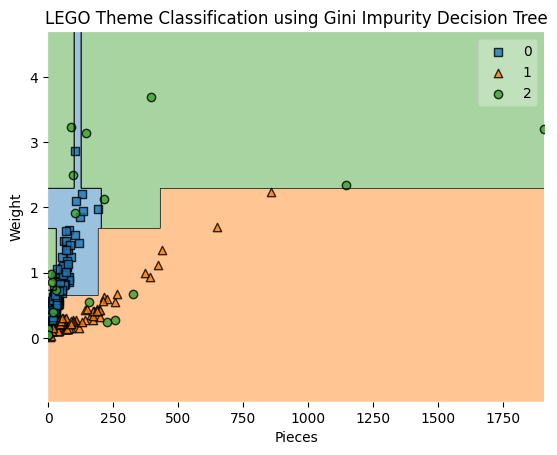

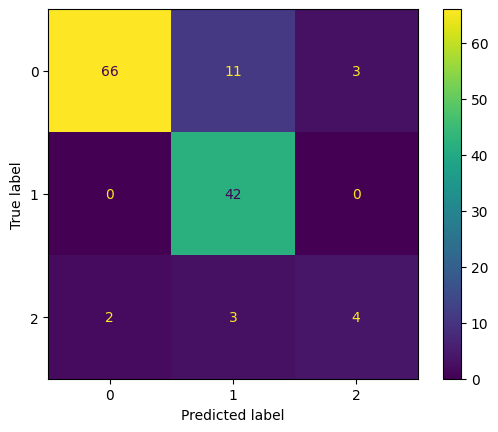

              precision    recall  f1-score   support

           0       0.97      0.82      0.89        80
           1       0.75      1.00      0.86        42
           2       0.57      0.44      0.50         9

    accuracy                           0.85       131
   macro avg       0.76      0.76      0.75       131
weighted avg       0.87      0.85      0.85       131



In [6]:
# Train decision tree
dt_gini = DecisionTreeClassifier(5)
dt_gini.train(X_train, y_train, gini_impurity)

# Plot decision boundaries
plot_decision_regions(X_train, y_train, clf=dt_gini)
plt.title("LEGO Theme Classification using Gini Impurity Decision Tree")
plt.xlabel("Pieces")
plt.ylabel("Weight")
plt.show()

# Make predictions on testing data
prediction = dt_gini.predict(X_test)

# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()

# Classifier metrics
print(metrics.classification_report(y_test, prediction))

From the decision-boundary plot, we see that the decision tree makes a reasonable partition of the feature space. The blue and orange spaces capture the bulk of the Duplo and Bionicles sets, respectively. The green space tries to capture the Education sets interdispersed within the Duplo and Bionicles sets.

Similar to k-nearest neighbors, the decision tree classifier does a good job identifying the Duplo and Bionicle LEGO sets (labels 0, 1) but does a bad job identifying the Education sets (label 2). As we saw in the first scatterplot, the Education sets' features are very well-mixed into the features of the Duplo and Bionicles sets, making the Education sets hard to separate. As a whole, this is a decent classification.

### Testing the Entropy decision tree
We can train a decision tree classifier using entropy instead of Gini impurity. Let's see how that affects the results.

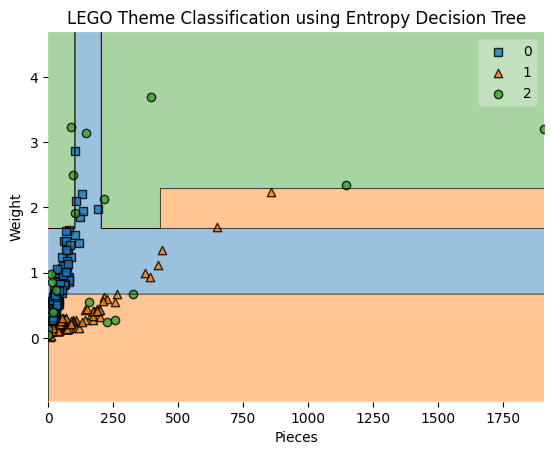

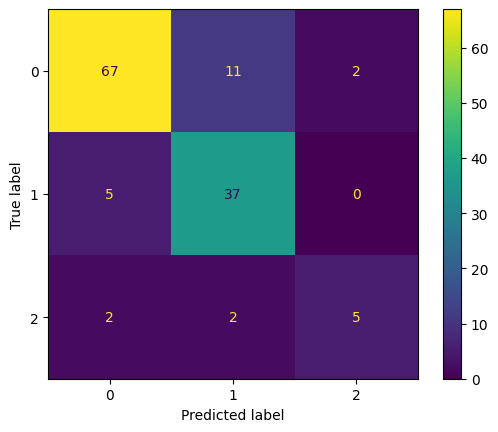

              precision    recall  f1-score   support

           0       0.91      0.84      0.87        80
           1       0.74      0.88      0.80        42
           2       0.71      0.56      0.63         9

    accuracy                           0.83       131
   macro avg       0.79      0.76      0.77       131
weighted avg       0.84      0.83      0.83       131



In [7]:
# Train decision tree
dt_entropy = DecisionTreeClassifier(5)
dt_entropy.train(X_train, y_train, entropy)

# Plot decision boundaries
plot_decision_regions(X_train, y_train, clf=dt_entropy)
plt.title("LEGO Theme Classification using Entropy Decision Tree")
plt.xlabel("Pieces")
plt.ylabel("Weight")
plt.show()

# Make predictions on testing data
prediction = dt_entropy.predict(X_test)

# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()

# Classifier metrics
print(metrics.classification_report(y_test, prediction))

The entropy-based classifier performs about the same as the Gini-impurity-based classifier. However, from the decision-boundary plot, we observe that the entropy-based classifier favors bulky, wide partitions of the feature space, whereas the Gini-impurity-based classifier opted for narrower, squigglier decision boundaries. 

### Adding a third feature: RRP
Of course, a decision tree can handle more than just two input features. What happens if we add the retail-recommended price as a third input feature? As we mentioned for the k-nearest neighbors demo, the Education sets tend to be slightly more expensive than the other two sets, we perhaps the RRP can help separate the Education sets.

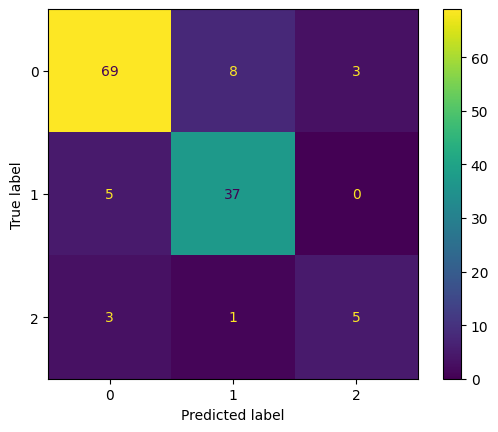

              precision    recall  f1-score   support

           0       0.90      0.86      0.88        80
           1       0.80      0.88      0.84        42
           2       0.62      0.56      0.59         9

    accuracy                           0.85       131
   macro avg       0.78      0.77      0.77       131
weighted avg       0.85      0.85      0.85       131



In [8]:
# Train/test split of data
X_train2, X_test2, y_train2, y_test2 = train_test_split(df[["Pieces", "Weight", "RRP"]].to_numpy(),
                                                    df["Indicator"].to_numpy(), 
                                                    test_size=0.3, 
                                                    random_state=0)

# Train decision tree
dt_gini2 = DecisionTreeClassifier(5)
dt_gini2.train(X_train2, y_train2, gini_impurity)

# Make predictions on testing data
prediction = dt_gini2.predict(X_test2)

# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test2, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()

# Classifier metrics
print(metrics.classification_report(y_test2, prediction))

Hmmm. Adding the RRP as a third feature did not really change model performance at all. The 3-feature model still does a good job identifying Duplo and Bionicles sets and still struggles to find the Education sets. This is perhaps not entirely unexpected, since, as mentioned before, the Education sets are very mixed into the other two sets' feature spaces.

## Regression
Decision trees can also be used for regression--that is, predicting the value for a continuous response variable instead of the label for a categorical response variable. The branching strategy is similar but to classification, but a different technique is used to determine how to split the feature space.

For brevity, we will just use a packaged decision tree regression model instead of implementing our own from scratch. We want to see if we can predict a LEGO set's retailer recommended price based on the set's weight, pieces count, and minifigure count.

          Pieces    Weight  Minifigs     RRP
Number                                      
75252-1   4784.0  12.42000       2.0  699.99
10261-1   4124.0   5.80000      11.0  379.99
10188-1   3803.0   8.31000      24.0  399.99
10303-1   3756.0   5.83000      11.0  399.99
70657-1   3553.0   4.61000      14.0  229.99
...          ...       ...       ...     ...
5678-1       4.0   0.06000       1.0    4.99
71012-12     3.0   0.01362       1.0    3.99
71009-4      3.0   0.00000       1.0    3.99
71012-1      3.0   0.01362       1.0    3.99
71012-2      3.0   0.01362       1.0    3.99

[2658 rows x 4 columns]


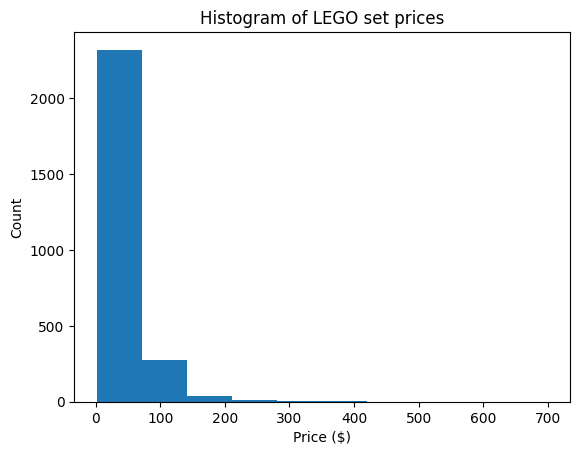

In [9]:
# Read in dataset and keep relevant columns/rows
df = pd.read_csv('data/Brickset-Most-Owned-Query-33-02042023.csv', index_col="Number")
df = df.filter(["Pieces", "Weight", "Minifigs", "RRP (USD)"])
df.columns = ["Pieces", "Weight", "Minifigs", "RRP"]
df = df.dropna()
print(df)

# Train/test split of data
X_train, X_test, y_train, y_test = train_test_split(df[["Pieces", "Weight"]].to_numpy(),
                                                    df["RRP"].to_numpy(), 
                                                    test_size=0.3, 
                                                    random_state=0)

# Visualize distribution of prices
plt.hist(df["RRP"])
plt.title("Histogram of LEGO set prices")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.show()

We see that the prices are distributed approximately exponentially, whereas the log of the prices are distributed approximately normally. This indicates that a regression model may have more success predicting the log of the prices instead of the original prices, since regression models perform best when the response variable is symmetrically distributed.

### Create and train decision tree regression model
Instead of implementing the decision tree from scratch, we'll use a prebuilt one from `sklearn`.

In [10]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(max_depth=5)
_ = dt_reg.fit(X_train, y_train)

### Test the decision tree regressor
Let's see how our regression model perform on the testing data.

Mean squared error on testing data: 177.27687032903586
Average error on testing data:      7.178140615648469


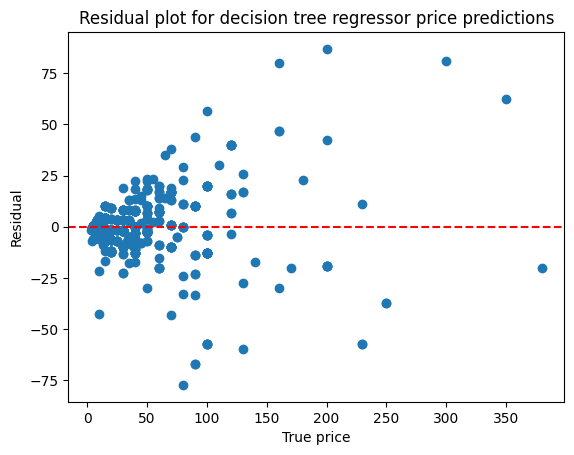

In [11]:
prediction = dt_reg.predict(X_test)
print("Mean squared error on testing data: " + str(np.mean(np.square(y_test - prediction))))
print("Average error on testing data:      " + str(np.mean(np.abs(y_test - prediction))))

plt.scatter(y_test, y_test - prediction)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residual plot for decision tree regressor price predictions")
plt.xlabel("True price")
plt.ylabel("Residual")
plt.show()

The regression is decent. On average, the regressor's predicted price is off by 7.18 USD for the training data LEGO sets. This is somewhat reasonable, considering that the average lego set is 38.04 USD. Furthermore, the residual plot is fairly randomly distributed about the horizontal reference line (red). Unfortunately, the variance of the residuals seems to grow wide as the true price increases. Recall that the residuals are equal to the actual value minus the predicted value, and a strong regression will show residuals distributed randomly and evenly about the horizontal reference line.